In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mplsoccer.pitch import Pitch
import numpy as np
import seaborn as sns
import ipywidgets as widgets

#Read in the data
df = pd.read_csv('Footballdata/New/NewcastlevsArsenal.csv', encoding='latin-1', low_memory=False)
df = df.fillna(0)

#Adjust for pitch size
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8

#remove substitution events,challenges & formation change
df = df.loc[~(df['type_displayName'] == 'SubstitutionOff')]
df = df.loc[~(df['type_displayName'] == 'SubstitutionOn')]
df = df.loc[~(df['type_displayName'] == 'FormationChange')]
df = df.loc[~(df['type_displayName'] == 'Challenge')]

#remove the records of a failed aerial, they should be ignored as their challenges are failed and the shot continues
df = df.loc[~((df['type_displayName'] == 'Aerial') & (df['outcomeType_displayName'] == 'Unsuccessful'))]

#Import xT Grid/EPVGrid
xT = pd.read_csv("xTGrid.csv", header=None)
#xT = pd.read_csv("EPVGrid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

#Creating Bins
df['x1_bin'] = pd.cut(df['x'], bins=xT_cols, labels=False)
df['y1_bin'] = pd.cut(df['y'], bins=xT_rows, labels=False)
df['x2_bin'] = pd.cut(df['endX'], bins=xT_cols, labels=False)
df['y2_bin'] = pd.cut(df['endY'], bins=xT_rows, labels=False)

#Combo box, choose team
options = df["teamId"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
teamlist = widgets.Combobox(
    placeholder='Enter a team',
    options=options,
    description='Team:',
    ensure_option=True,
    disabled=False
)
teamlist

Combobox(value='', description='Team:', ensure_option=True, options=('Arsenal', 'Newcastle'), placeholder='Ent…

In [2]:
#Filter for team
team = teamlist.value

df = df.loc[(df['outcomeType_displayName']=='Successful') & 
            (df['teamId'] == team) &
            (df['type_displayName']=='Pass') &
            (df['x'] < 119.3)]

# Return Bin Values for xT
# We use a lambda function to assign the values from the bins to the x and y values with numpy array slicing
# it is going through each row and assigning the values based on where those numbers are in the numpy array
# xT[4][5] where 4 is the fourth list and 5 is the fifth item in that list

df['start_zone_value'] = df[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)
df['end_zone_value'] = df[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)

# now we find the difference between the start and end to get the xT value
df['xT'] = df['end_zone_value'] - df['start_zone_value']

In [3]:
#Grouping the players with the sum of their xT's from passes in the game
xT1 = df.groupby('playername').agg({'xT':['sum']})
xT1.columns = ['xT']

#Creating a new dataframe to store everything, to get playername as a variable
xTList = xT1['xT'].to_frame(name='SUM').reset_index()
xTList.columns = ['Player','xT']
xTList = xTList.sort_values(by='xT',ascending=False)
xTList

#xTList = xTList.head(10)

#Round to 4dp for labels & only taking the positive xTs as labels
y = xTList.xT.round(2)
y = y[y>0]

xTList

,Player,xT
11,Kieran Trippier,0.613675
8,Jacob Murphy,0.382632
0,Alexander Isak,0.115920
3,Bruno GuimarÃ£es,0.087385
15,Sven Botman,0.062628
5,Dan Burn,0.026202
14,Nick Pope,0.025715
7,Fabian SchÃ¤r,0.019821
10,Joelinton,0.018196
1,Allan Saint-Maximin,0.016683


In [4]:
#List of Successful Passes
SuccessfulPass = df
successful_pass_list = SuccessfulPass.groupby(['playername']).size().reset_index().rename(columns={0:'Successful Passes'}).sort_values('playername', ascending = True).reset_index()
del successful_pass_list['index']
successful_pass_list.columns = ['Player','Successful Passes']
#successful_pass_list

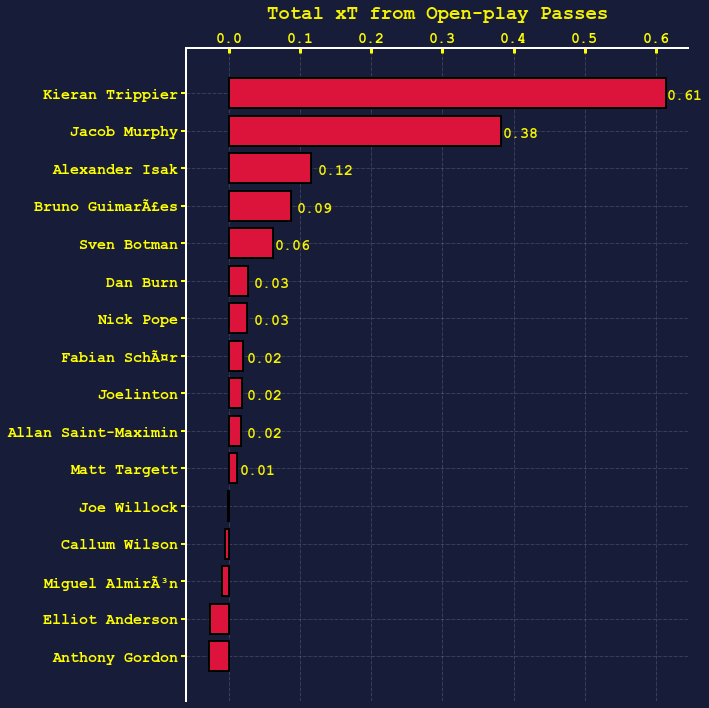

In [6]:
# Figure Size
fig, ax = plt.subplots(figsize=(9,12))
fig.set_facecolor('#171c38')
#mpl.rcParams['figure.dpi'] = 300

# Horizontal Bar Plot
bar = ax.barh(xTList.iloc[:,0],xTList.iloc[:,1], color="crimson", edgecolor='black',lw=2,zorder=3)
ax.set_facecolor('#171c38')

ax.tick_params(axis='y', colors='yellow')
ax.tick_params(axis='x', colors='yellow')

ax.grid(zorder=0)
    
# Remove axes spines
for s in ['right','bottom']:
    ax.spines[s].set_visible(False)

#Set spine width & color
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['left'].set_color('white')
ax.spines['top'].set_color('white')

# Remove x,y Ticks
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=3, width=3,length=5,direction='in')
ax.yaxis.set_tick_params(pad=3, width=2,length=5)


# Add x,y gridlines
ax.grid(color='white', linestyle='-.', linewidth=0.5, alpha=0.3)

# Show top values 
ax.invert_yaxis()

# Add Plot Title
ax.set_title("Total xT from Open-play Passes",va='center_baseline',
             loc='center', fontsize=19, fontweight='bold', pad=20,
             color='#f5f201',fontfamily='Courier New')

#Setting Plot fonts
font = {'family' : 'Courier New',
        'weight' : 'bold',
        'size' : 15}

mpl.rc('font', **font)

"""# Add Text watermark
fig.text(0.9, 0.15, "@chunhang7\nxT Values from Karun Singh's Model", fontsize=14, color='#f5f201',
         ha='right', va='bottom', alpha=0.5, fontweight='bold', fontfamily='Courier New')
"""
#The values,numbers
for index, value in enumerate(y):
   ax.text(value+.005, index-0.1, str(value), color ='#f5f201',fontweight='bold', ha='left', va='top',fontsize='15')
    
# Show Plot
plt.show()

In [6]:
#Merge
xTper100passeslist = pd.merge(xTList, successful_pass_list, on="Player")
xTper100passeslist
xTper100passeslist['xT_per_100_Passes'] =((xTper100passeslist['xT'] / xTper100passeslist['Successful Passes'])*302).round(decimals = 2)
xTper100passeslist = xTper100passeslist.sort_values('xT_per_100_Passes', ascending = False).reset_index()
del xTper100passeslist['index']
result = xTper100passeslist.drop(columns=['xT', 'Successful Passes'])

#result = result.head(10)

#Round to 4dp for labels & only taking the positive xTs as labels
c = result.xT_per_100_Passes.round(4)
c = c[c>0]

xTper100passeslist

,Player,xT,Successful Passes,xT_per_100_Passes
0,Marcus Rashford,0.313888,19,4.99
1,Diogo Dalot,0.181466,55,1.00
2,Donny van de Beek,0.003233,1,0.98
3,Jadon Sancho,0.039094,26,0.45
4,Harry Maguire,0.066729,46,0.44
5,Raphaël Varane,0.031151,22,0.43
6,Scott McTominay,0.034322,26,0.40
7,David de Gea,0.013419,13,0.31
8,Christian Eriksen,0.050601,61,0.25
9,Luke Shaw,0.023156,36,0.19


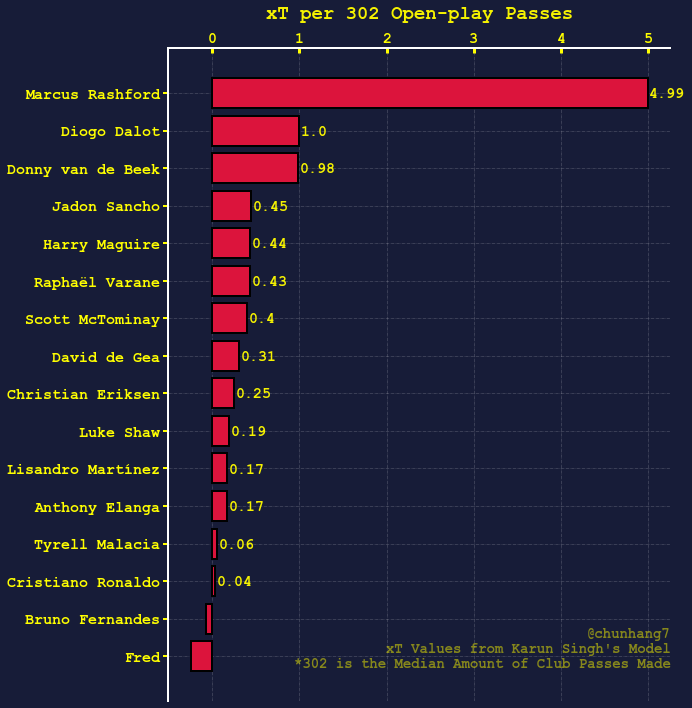

In [7]:
# Figure Size
fig, ax = plt.subplots(figsize=(9,12))
fig.set_facecolor('#171c38')

# Horizontal Bar Plot
bar = ax.barh(result.iloc[:,0],result.iloc[:,1], color="crimson", edgecolor='black',lw=2,zorder=3)
ax.set_facecolor('#171c38')

ax.tick_params(axis='y', colors='yellow')
ax.tick_params(axis='x', colors='yellow')

ax.grid(zorder=0)
    
# Remove axes spines
for s in ['right','bottom']:
    ax.spines[s].set_visible(False)

#Set spine width & color
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['left'].set_color('white')
ax.spines['top'].set_color('white')

# Remove x,y Ticks
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=3, width=3,length=5,direction='in')
ax.yaxis.set_tick_params(pad=3, width=2,length=5)


# Add x,y gridlines
ax.grid(color='white', linestyle='-.', linewidth=0.5, alpha=0.3)

# Show top values 
ax.invert_yaxis()

# Add Plot Title
ax.set_title("xT per 302 Open-play Passes",va='center_baseline',
             loc='center', fontsize=19, fontweight='bold', pad=20,
             color='#f5f201',fontfamily='Courier New')

#Setting Plot fonts
font = {'family' : 'Courier New',
        'weight' : 'bold',
        'size' : 15}

mpl.rc('font', **font)

# Add Text watermark
fig.text(0.9, 0.16, "@chunhang7\nxT Values from Karun Singh's Model\n*302 is the Median Amount of Club Passes Made", 
         fontsize=14, color='#f5f201', ha='right', va='bottom', alpha=0.5, fontweight='bold', fontfamily='Courier New')

#The values,numbers
for index, value in enumerate(c):
   ax.text(value+0.02, index-0.15, str(value), color ='#f5f201',fontweight='bold', ha='left', va='top',fontsize='15')
    

# Show Plot
plt.show()